Library by Library Collection Dates

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

Utilize the Louisville Public Library Collection data. Downloaded 12/18/2024 from https://data.louisvilleky.gov/

In [2]:
# makes list of file paths
file_paths = [f'librarycollection/collection_{i}.csv' for i in range(1, 26)]

# Reads data from each file into a DataFrame
dataframes = [pd.read_csv(file) for file in file_paths]

# Concatenate all DataFrames into one
library_collection = pd.concat(dataframes, ignore_index=True)

Cleaning Data

In [3]:
# This drops unncessary columns and electronic or non-book items
def cleaning_data(library_collection):
    library_collection = library_collection.dropna(subset = ["ItemCollection", "ItemLocation"])
    library_collection = library_collection.drop(['BibNum', 'Title','Author','ISBN','ReportDate','ObjectId'], axis=1)
    library_collection = library_collection[~library_collection["ItemCollection"].isin(["Music", "Listening Device", 
                                                                                        "Children's Music", "Children's DVD", 
                                                                                        "Laptop", "Adult DVD", "Interlibrary Loan", "NaN",
                                                                                        "Electronic", "Adult Blu-Ray", "Children's Blu-ray",
                                                                                        "Digital Camera","Telescope","Hotspot","Board Game", "Launchpad"])]
    
    return library_collection
librarycleaner = cleaning_data(library_collection)

In [4]:
def combining_collections(librarycleaner):
    """
    This function combines ItemCollection into adult, teen, and children. 
    It also removes collections that cannot be sorted by age. The categories and sorting are:
Adult = Adult Non-Fiction, Adult Fiction, Adult Paperback, Adult Audiobook, Adult Reference, 
    Adult Paperbacks Tall, Mystery, Kentucky History, Large Print, Science Fiction, International Collection, 
    Magazines and Newspaper, Government Documents, Urban Fiction, Western
Teen = Teen Non-Fiction, Older Teen Fiction, Younger Teen  Fiction, Younger Teen  Audiobook, 
    OlderTeen Audiobook, Younger Teen  Paperback, Older Teen Paperback, Teen Non-Fiction Audiobook, 
    College Shop, Teen Reference  
Children = Children's Non-Fiction, Children's Picture Book, Preschool Picture Book, Children's Fiction, 
    Children's Paperback, Children's Easy Reader, Children's Board Book, Children's Easy Reader Paperback, 
    Children's Picture Paperback, Children's Audiobook, Storytime Collection, Readalongs, Children's Magazine, 
    Children's Reference, Children's Non-Fiction Paperback  
Unsorted/removed = Caldecott/Newbery, Oversize, ELL Collection, Bestsellers, Natural Resources, 
    Book Discussion Kit, Big Book, Telereference, Holiday

The second part of the function simplifies the locations of the items.
    Remote Shelving - Main is combined with Main
    Childrens Main Library is combined with Main
    Main Teen is combined with Main
    Remote Shelving - Shawnee is combined with Shawnee
    Childrens Bookmobile, Adult Bookmobile, and Content Management are removed as they have no physical location
    """
    librarycleaner = librarycleaner[~librarycleaner["ItemCollection"].isin(["Caldecott/Newbery", "Oversize", "ELL Collection",
                                                                            "Bestsellers", "Natural Resources", 
                                                                            "Book Discussion Kit", "Big Book", "Telereference", "Holiday"])]
    librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Adult Non-Fiction", "Adult Fiction", "Adult Paperback", "Adult Audiobook", 
                                                                                 "Adult Reference", "Adult Paperbacks Tall", "Mystery", "Kentucky History", 
                                                                                 "Large Print", "Science Fiction", "International Collection", 
                                                                                 "Magazines and Newspaper", "Government Documents", "Urban Fiction", 
                                                                                 "Western"], "Adult")
    librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Teen Non-Fiction", "Older Teen Fiction", "Younger Teen  Fiction", 
                                                                                 "Younger Teen  Audiobook", "OlderTeen Audiobook", "Younger Teen  Paperback", 
                                                                                 "Older Teen Paperback", "Teen Non-Fiction Audiobook", "College Shop",
                                                                                 "Teen Reference"], "Teen")
    librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Children's Non-Fiction", "Children's Picture Book", "Preschool  Picture Book", 
                                                                                 "Children's Fiction", "Children's Paperback", "Children's Easy Reader", 
                                                                                 "Children's Board Book", "Children's Easy Reader Paperback", "Children's Picture Paperback", 
                                                                                 "Children's Audiobook", "Storytime Collection", "Readalongs", "Children's Magazine", 
                                                                                 "Children's Reference", "Children's Non-Fiction Paperback"], "Children")
    librarycleaner = librarycleaner[~librarycleaner["ItemLocation"].isin(["Childrens Bookmobile", "Adult Bookmobile", "Content Management"])]
    librarycleaner["ItemLocation"] = librarycleaner["ItemLocation"].replace(["Remote Shelving - Main", "Childrens Main Library", "Main Teen"], "Main")
    librarycleaner["ItemLocation"] = librarycleaner["ItemLocation"].replace("Remote Shelving - Shawnee", "Shawnee")
    return(librarycleaner)
librarysorted = combining_collections(librarycleaner)

C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_5476\166721550.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Adult Non-Fiction", "Adult Fiction", "Adult Paperback", "Adult Audiobook",
C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_5476\166721550.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Teen Non-Fiction", "Older Teen Fiction", 

In [5]:
# this aligns the names with the formatting of the geojson
replacements = {'Northeast': 'NORTHEAST REGIONAL', 'South Central': 'SOUTH CENTRAL REGIONAL', 'Southwest': 'SOUTHWEST BRANCH',
                'Main': 'MAIN', 'Portland': 'PORTLAND', 'Iroquois': 'IROQUOIS', 
                'Highlands - Shelby Park': 'HIGHLANDS-SHELBY PARK', 'Bon Air': 'BON AIR REGIONAL',
                'St Matthews': 'ST. MATTHEWS/ELINE', 'Western': 'WESTERN', 'Shawnee': 'SHAWNEE', 'Crescent Hill': 'CRESCENT HILL',
                'Jeffersontown': 'JEFFERSONTOWN', 'Fairdale': 'FAIRDALE', 'Middletown': 'MIDDLETOWN', 'Newburg': 'NEWBURG',
                'Shively': 'SHIVELY'}
librarysorted2 = librarysorted.replace(replacements)

In [6]:
# This drops teen and children since only adult education is in the Census data
librarysortedadult = librarysorted2[~librarysorted.ItemCollection.str.contains("Teen", "Children")]
library_by_year = librarysortedadult[['PublicationYear','ItemLocation']].groupby(['ItemLocation']).value_counts(normalize=True).reset_index(name='Percent')
library_by_year['Percent'] = library_by_year['Percent'] * 100
library_by_year1 = library_by_year[library_by_year.PublicationYear != 0]

In [7]:
# separates the data into libraries so that percentages of publication dates can be made for each

northeast = library_by_year1.loc[library_by_year1['ItemLocation'] == 'NORTHEAST REGIONAL']
southeast = library_by_year1.loc[library_by_year1['ItemLocation'] == 'SOUTH CENTRAL REGIONAL']
southwest = library_by_year1.loc[library_by_year1['ItemLocation'] == 'SOUTHWEST BRANCH']
main = library_by_year1.loc[library_by_year1['ItemLocation'] == 'MAIN']
portland = library_by_year1.loc[library_by_year1['ItemLocation'] == 'PORTLAND']
iroquois = library_by_year1.loc[library_by_year1['ItemLocation'] == 'IROQUOIS']
highlands = library_by_year1.loc[library_by_year1['ItemLocation'] == 'HIGHLANDS-SHELBY PARK']
bonair = library_by_year1.loc[library_by_year1['ItemLocation'] == 'BON AIR REGIONAL']
matthews = library_by_year1.loc[library_by_year1['ItemLocation'] == 'ST. MATTHEWS/ELINE']
western = library_by_year1.loc[library_by_year1['ItemLocation'] == 'WESTERN']
shawnee = library_by_year1.loc[library_by_year1['ItemLocation'] == 'SHAWNEE']
crescent = library_by_year1.loc[library_by_year1['ItemLocation'] == 'CRESCENT HILL']
jtown = library_by_year1.loc[library_by_year1['ItemLocation'] == 'JEFFERSONTOWN']
fairdale = library_by_year1.loc[library_by_year1['ItemLocation'] == 'FAIRDALE']
middletown = library_by_year1.loc[library_by_year1['ItemLocation'] == 'MIDDLETOWN']
newburg = library_by_year1.loc[library_by_year1['ItemLocation'] == 'NEWBURG']
shively = library_by_year1.loc[library_by_year1['ItemLocation'] == 'SHIVELY']


In [8]:

def year_divisions(x):
    """This function seperates publications into year segments for each library
    the segments increase in size as they go back in time, pre-1900 is omitted"""
    x_1 = x[x['PublicationYear'].isin([2020, 2021, 2022, 2023, 2024, 2025])]
    x['2020-2025'] = x_1['Percent'].sum()
    x_2 = x[x['PublicationYear'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
    x['2010-2019'] = x_2['Percent'].sum()
    x_3 = x[x['PublicationYear'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009])]
    x['2000-2009'] = x_3['Percent'].sum()
    x_4 = x[x['PublicationYear'].isin([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])]
    x['1990-1999'] = x_4['Percent'].sum()
    x_5 = x[x['PublicationYear'].isin([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989])]
    x['1980-1989'] = x_5['Percent'].sum()
    x_6 = x[x['PublicationYear'].isin([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979])]
    x['1970-1979'] = x_6['Percent'].sum()
    x_7 = x[x['PublicationYear'].isin([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 
                                       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969])]
    x['1950-1969'] = x_7['Percent'].sum()
    x_8  = x[x['PublicationYear'].isin([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 
                                        1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 
                                        1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 
                                        1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
                                        1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949])]
    x['1900-1949'] = x_6['Percent'].sum()
    x.drop(['PublicationYear', 'Percent'], axis=1, inplace=True)
    x.drop(x.index[1:], inplace=True)
    return(x)

north_east = year_divisions(northeast)
south_east = year_divisions(southeast)
south_west = year_divisions(southwest)
main_main = year_divisions(main)
port_land = year_divisions(portland)
iro_quois = year_divisions(iroquois)
high_lands = year_divisions(highlands)
bon_air = year_divisions(bonair)
matt_hews = year_divisions(matthews)
west_ern = year_divisions(western)
shaw_nee = year_divisions(shawnee)
cres_cent = year_divisions(crescent)
j_town = year_divisions(jtown)
fair_dale = year_divisions(fairdale)
middle_town = year_divisions(middletown)
new_burg = year_divisions(newburg)
shive_ly = year_divisions(shively)


C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_5476\1082257331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['2020-2025'] = x_1['Percent'].sum()
C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_5476\1082257331.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['2010-2019'] = x_2['Percent'].sum()
C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_5476\1082257331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [9]:
# This combines the individual library files into 1 dataset
library_yearly = pd.concat([north_east, south_east, south_west, main_main, port_land, iro_quois, high_lands, 
                            bon_air, matt_hews, west_ern, shaw_nee, cres_cent, j_town, fair_dale, middle_town,
                            new_burg, shive_ly])

In [10]:
# This adds a column for zipcodes
map_dict = {'BON AIR REGIONAL':'40220', 'CRESCENT HILL': '40206', 'FAIRDALE': '40118', 'HIGHLANDS-SHELBY PARK': '40204', 
            'IROQUOIS': '40215', 'JEFFERSONTOWN': '40299', 'MAIN': '40203', 'MIDDLETOWN': '40243', 'NEWBURG': '40218', 
            'NORTHEAST REGIONAL': '40223', 'PORTLAND': '40212', 'SHAWNEE': '40211', 'SHIVELY': '40216', 'SOUTH CENTRAL REGIONAL': '40219', 
            'SOUTHWEST BRANCH': '40272', 'ST. MATTHEWS/ELINE': '40207', 'WESTERN': '40203'}

library_yearly["zipcode"] = library_yearly["ItemLocation"].map(map_dict)             

Bring in education level data for each zipcode from data.census.gov (downloaded 2/26/25)

In [11]:
# read in the datasets
ed_40023 = pd.read_csv("zip_education/40023.ed.csv")
ed_40025 = pd.read_csv("zip_education/40025.ed.csv")
ed_40041 = pd.read_csv("zip_education/40041.ed.csv")
ed_40047 = pd.read_csv("zip_education/40047.ed.csv")
ed_40059 = pd.read_csv("zip_education/40059.ed.csv")
ed_40067 = pd.read_csv("zip_education/40067.ed.csv")
ed_40118 = pd.read_csv("zip_education/40118.ed.csv")
ed_40177 = pd.read_csv("zip_education/40177.ed.csv")
ed_40202 = pd.read_csv("zip_education/40202.ed.csv")
ed_40203 = pd.read_csv("zip_education/40203.ed.csv")
ed_40204 = pd.read_csv("zip_education/40204.ed.csv")
ed_40205 = pd.read_csv("zip_education/40205.ed.csv")
ed_40206 = pd.read_csv("zip_education/40206.ed.csv")
ed_40207 = pd.read_csv("zip_education/40207.ed.csv")
ed_40208 = pd.read_csv("zip_education/40208.ed.csv")
ed_40209 = pd.read_csv("zip_education/40209.ed.csv")
ed_40210 = pd.read_csv("zip_education/40210.ed.csv")
ed_40211 = pd.read_csv("zip_education/40211.ed.csv")
ed_40212 = pd.read_csv("zip_education/40212.ed.csv")
ed_40213 = pd.read_csv("zip_education/40213.ed.csv")
ed_40214 = pd.read_csv("zip_education/40214.ed.csv")
ed_40215 = pd.read_csv("zip_education/40215.ed.csv")
ed_40216 = pd.read_csv("zip_education/40216.ed.csv")
ed_40217 = pd.read_csv("zip_education/40217.ed.csv")
ed_40218 = pd.read_csv("zip_education/40218.ed.csv")
ed_40219 = pd.read_csv("zip_education/40219.ed.csv")
ed_40220 = pd.read_csv("zip_education/40220.ed.csv")
ed_40222 = pd.read_csv("zip_education/40222.ed.csv")
ed_40223 = pd.read_csv("zip_education/40223.ed.csv")
ed_40228 = pd.read_csv("zip_education/40228.ed.csv")
ed_40229 = pd.read_csv("zip_education/40229.ed.csv")
ed_40241 = pd.read_csv("zip_education/40241.ed.csv")
ed_40242 = pd.read_csv("zip_education/40242.ed.csv")
ed_40243 = pd.read_csv("zip_education/40243.ed.csv")
ed_40245 = pd.read_csv("zip_education/40245.ed.csv")
ed_40258 = pd.read_csv("zip_education/40258.ed.csv")
ed_40272 = pd.read_csv("zip_education/40272.ed.csv")
ed_40291 = pd.read_csv("zip_education/40291.ed.csv")
ed_40299 = pd.read_csv("zip_education/40299.ed.csv")


In [12]:
# This drops unnecessary columns and rows and renames the rest
ed_40023.drop(['ZCTA5 40023!!Total!!Margin of Error',
               'ZCTA5 40023!!Percent!!Estimate',
               'ZCTA5 40023!!Percent!!Margin of Error',
               'ZCTA5 40023!!Male!!Estimate',
               'ZCTA5 40023!!Male!!Margin of Error',
               'ZCTA5 40023!!Percent Male!!Estimate',
               'ZCTA5 40023!!Percent Male!!Margin of Error',
               'ZCTA5 40023!!Female!!Estimate',
               'ZCTA5 40023!!Female!!Margin of Error',
               'ZCTA5 40023!!Percent Female!!Estimate',
               'ZCTA5 40023!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40023 = ed_40023.drop(ed_40023.index[28:])
ed_40023 = ed_40023.rename(columns={"ZCTA5 40023!!Total!!Estimate": "Total"})
ed_40023["zipcode"] = "40023"

ed_40025.drop(['ZCTA5 40025!!Total!!Margin of Error',
               'ZCTA5 40025!!Percent!!Estimate',
               'ZCTA5 40025!!Percent!!Margin of Error',
               'ZCTA5 40025!!Male!!Estimate',
               'ZCTA5 40025!!Male!!Margin of Error',
               'ZCTA5 40025!!Percent Male!!Estimate',
               'ZCTA5 40025!!Percent Male!!Margin of Error',
               'ZCTA5 40025!!Female!!Estimate',
               'ZCTA5 40025!!Female!!Margin of Error',
               'ZCTA5 40025!!Percent Female!!Estimate',
               'ZCTA5 40025!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40025 = ed_40025.drop(ed_40025.index[28:])
ed_40025 = ed_40025.rename(columns={"ZCTA5 40025!!Total!!Estimate": "Total"})
ed_40025["zipcode"] = "40025"

ed_40041.drop(['ZCTA5 40041!!Total!!Margin of Error',
               'ZCTA5 40041!!Percent!!Estimate',
               'ZCTA5 40041!!Percent!!Margin of Error',
               'ZCTA5 40041!!Male!!Estimate',
               'ZCTA5 40041!!Male!!Margin of Error',
               'ZCTA5 40041!!Percent Male!!Estimate',
               'ZCTA5 40041!!Percent Male!!Margin of Error',
               'ZCTA5 40041!!Female!!Estimate',
               'ZCTA5 40041!!Female!!Margin of Error',
               'ZCTA5 40041!!Percent Female!!Estimate',
               'ZCTA5 40041!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40041 = ed_40041.drop(ed_40041.index[28:])
ed_40041 = ed_40041.rename(columns={"ZCTA5 40041!!Total!!Estimate": "Total"})
ed_40041["zipcode"] = "40041"

ed_40047.drop(['ZCTA5 40047!!Total!!Margin of Error',
               'ZCTA5 40047!!Percent!!Estimate',
               'ZCTA5 40047!!Percent!!Margin of Error',
               'ZCTA5 40047!!Male!!Estimate',
               'ZCTA5 40047!!Male!!Margin of Error',
               'ZCTA5 40047!!Percent Male!!Estimate',
               'ZCTA5 40047!!Percent Male!!Margin of Error',
               'ZCTA5 40047!!Female!!Estimate',
               'ZCTA5 40047!!Female!!Margin of Error',
               'ZCTA5 40047!!Percent Female!!Estimate',
               'ZCTA5 40047!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40047 = ed_40047.drop(ed_40047.index[28:])
ed_40047 = ed_40047.rename(columns={"ZCTA5 40047!!Total!!Estimate": "Total"})
ed_40047["zipcode"] = "40047"

ed_40059.drop(['ZCTA5 40059!!Total!!Margin of Error',
               'ZCTA5 40059!!Percent!!Estimate',
               'ZCTA5 40059!!Percent!!Margin of Error',
               'ZCTA5 40059!!Male!!Estimate',
               'ZCTA5 40059!!Male!!Margin of Error',
               'ZCTA5 40059!!Percent Male!!Estimate',
               'ZCTA5 40059!!Percent Male!!Margin of Error',
               'ZCTA5 40059!!Female!!Estimate',
               'ZCTA5 40059!!Female!!Margin of Error',
               'ZCTA5 40059!!Percent Female!!Estimate',
               'ZCTA5 40059!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40059 = ed_40059.drop(ed_40059.index[28:])
ed_40059 = ed_40059.rename(columns={"ZCTA5 40059!!Total!!Estimate": "Total"})
ed_40059["zipcode"] = "40059"

ed_40067.drop(['ZCTA5 40067!!Total!!Margin of Error',
               'ZCTA5 40067!!Percent!!Estimate',
               'ZCTA5 40067!!Percent!!Margin of Error',
               'ZCTA5 40067!!Male!!Estimate',
               'ZCTA5 40067!!Male!!Margin of Error',
               'ZCTA5 40067!!Percent Male!!Estimate',
               'ZCTA5 40067!!Percent Male!!Margin of Error',
               'ZCTA5 40067!!Female!!Estimate',
               'ZCTA5 40067!!Female!!Margin of Error',
               'ZCTA5 40067!!Percent Female!!Estimate',
               'ZCTA5 40067!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40067 = ed_40067.drop(ed_40067.index[28:])
ed_40067 = ed_40067.rename(columns={"ZCTA5 40067!!Total!!Estimate": "Total"})
ed_40067["zipcode"] = "40067"

ed_40118.drop(['ZCTA5 40118!!Total!!Margin of Error',
               'ZCTA5 40118!!Percent!!Estimate',
               'ZCTA5 40118!!Percent!!Margin of Error',
               'ZCTA5 40118!!Male!!Estimate',
               'ZCTA5 40118!!Male!!Margin of Error',
               'ZCTA5 40118!!Percent Male!!Estimate',
               'ZCTA5 40118!!Percent Male!!Margin of Error',
               'ZCTA5 40118!!Female!!Estimate',
               'ZCTA5 40118!!Female!!Margin of Error',
               'ZCTA5 40118!!Percent Female!!Estimate',
               'ZCTA5 40118!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40118 = ed_40118.drop(ed_40118.index[28:])
ed_40118 = ed_40118.rename(columns={"ZCTA5 40118!!Total!!Estimate": "Total"})
ed_40118["zipcode"] = "40118"

ed_40177.drop(['ZCTA5 40177!!Total!!Margin of Error',
               'ZCTA5 40177!!Percent!!Estimate',
               'ZCTA5 40177!!Percent!!Margin of Error',
               'ZCTA5 40177!!Male!!Estimate',
               'ZCTA5 40177!!Male!!Margin of Error',
               'ZCTA5 40177!!Percent Male!!Estimate',
               'ZCTA5 40177!!Percent Male!!Margin of Error',
               'ZCTA5 40177!!Female!!Estimate',
               'ZCTA5 40177!!Female!!Margin of Error',
               'ZCTA5 40177!!Percent Female!!Estimate',
               'ZCTA5 40177!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40177 = ed_40177.drop(ed_40177.index[28:])
ed_40177 = ed_40177.rename(columns={"ZCTA5 40177!!Total!!Estimate": "Total"})
ed_40177["zipcode"] = "40177"

ed_40202.drop(['ZCTA5 40202!!Total!!Margin of Error',
               'ZCTA5 40202!!Percent!!Estimate',
               'ZCTA5 40202!!Percent!!Margin of Error',
               'ZCTA5 40202!!Male!!Estimate',
               'ZCTA5 40202!!Male!!Margin of Error',
               'ZCTA5 40202!!Percent Male!!Estimate',
               'ZCTA5 40202!!Percent Male!!Margin of Error',
               'ZCTA5 40202!!Female!!Estimate',
               'ZCTA5 40202!!Female!!Margin of Error',
               'ZCTA5 40202!!Percent Female!!Estimate',
               'ZCTA5 40202!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40202 = ed_40202.drop(ed_40202.index[28:])
ed_40202 = ed_40202.rename(columns={"ZCTA5 40202!!Total!!Estimate": "Total"})
ed_40202["zipcode"] = "40202"

ed_40203.drop(['ZCTA5 40203!!Total!!Margin of Error',
               'ZCTA5 40203!!Percent!!Estimate',
               'ZCTA5 40203!!Percent!!Margin of Error',
               'ZCTA5 40203!!Male!!Estimate',
               'ZCTA5 40203!!Male!!Margin of Error',
               'ZCTA5 40203!!Percent Male!!Estimate',
               'ZCTA5 40203!!Percent Male!!Margin of Error',
               'ZCTA5 40203!!Female!!Estimate',
               'ZCTA5 40203!!Female!!Margin of Error',
               'ZCTA5 40203!!Percent Female!!Estimate',
               'ZCTA5 40203!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40203 = ed_40203.drop(ed_40203.index[28:])
ed_40203 = ed_40203.rename(columns={"ZCTA5 40203!!Total!!Estimate": "Total"})
ed_40203["zipcode"] = "40203"

ed_40204.drop(['ZCTA5 40204!!Total!!Margin of Error',
               'ZCTA5 40204!!Percent!!Estimate',
               'ZCTA5 40204!!Percent!!Margin of Error',
               'ZCTA5 40204!!Male!!Estimate',
               'ZCTA5 40204!!Male!!Margin of Error',
               'ZCTA5 40204!!Percent Male!!Estimate',
               'ZCTA5 40204!!Percent Male!!Margin of Error',
               'ZCTA5 40204!!Female!!Estimate',
               'ZCTA5 40204!!Female!!Margin of Error',
               'ZCTA5 40204!!Percent Female!!Estimate',
               'ZCTA5 40204!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40204 = ed_40204.drop(ed_40204.index[28:])
ed_40204 = ed_40204.rename(columns={"ZCTA5 40204!!Total!!Estimate": "Total"})
ed_40204["zipcode"] = "40204"

ed_40205.drop(['ZCTA5 40205!!Total!!Margin of Error',
               'ZCTA5 40205!!Percent!!Estimate',
               'ZCTA5 40205!!Percent!!Margin of Error',
               'ZCTA5 40205!!Male!!Estimate',
               'ZCTA5 40205!!Male!!Margin of Error',
               'ZCTA5 40205!!Percent Male!!Estimate',
               'ZCTA5 40205!!Percent Male!!Margin of Error',
               'ZCTA5 40205!!Female!!Estimate',
               'ZCTA5 40205!!Female!!Margin of Error',
               'ZCTA5 40205!!Percent Female!!Estimate',
               'ZCTA5 40205!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40205 = ed_40205.drop(ed_40205.index[28:])
ed_40205 = ed_40205.rename(columns={"ZCTA5 40205!!Total!!Estimate": "Total"})
ed_40205["zipcode"] = "40205"

ed_40206.drop(['ZCTA5 40206!!Total!!Margin of Error',
               'ZCTA5 40206!!Percent!!Estimate',
               'ZCTA5 40206!!Percent!!Margin of Error',
               'ZCTA5 40206!!Male!!Estimate',
               'ZCTA5 40206!!Male!!Margin of Error',
               'ZCTA5 40206!!Percent Male!!Estimate',
               'ZCTA5 40206!!Percent Male!!Margin of Error',
               'ZCTA5 40206!!Female!!Estimate',
               'ZCTA5 40206!!Female!!Margin of Error',
               'ZCTA5 40206!!Percent Female!!Estimate',
               'ZCTA5 40206!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40206 = ed_40206.drop(ed_40206.index[28:])
ed_40206 = ed_40206.rename(columns={"ZCTA5 40206!!Total!!Estimate": "Total"})
ed_40206["zipcode"] = "40206"

ed_40207.drop(['ZCTA5 40207!!Total!!Margin of Error',
               'ZCTA5 40207!!Percent!!Estimate',
               'ZCTA5 40207!!Percent!!Margin of Error',
               'ZCTA5 40207!!Male!!Estimate',
               'ZCTA5 40207!!Male!!Margin of Error',
               'ZCTA5 40207!!Percent Male!!Estimate',
               'ZCTA5 40207!!Percent Male!!Margin of Error',
               'ZCTA5 40207!!Female!!Estimate',
               'ZCTA5 40207!!Female!!Margin of Error',
               'ZCTA5 40207!!Percent Female!!Estimate',
               'ZCTA5 40207!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40207 = ed_40207.drop(ed_40207.index[28:])
ed_40207 = ed_40207.rename(columns={"ZCTA5 40207!!Total!!Estimate": "Total"})
ed_40207["zipcode"] = "40207"

ed_40208.drop(['ZCTA5 40208!!Total!!Margin of Error',
               'ZCTA5 40208!!Percent!!Estimate',
               'ZCTA5 40208!!Percent!!Margin of Error',
               'ZCTA5 40208!!Male!!Estimate',
               'ZCTA5 40208!!Male!!Margin of Error',
               'ZCTA5 40208!!Percent Male!!Estimate',
               'ZCTA5 40208!!Percent Male!!Margin of Error',
               'ZCTA5 40208!!Female!!Estimate',
               'ZCTA5 40208!!Female!!Margin of Error',
               'ZCTA5 40208!!Percent Female!!Estimate',
               'ZCTA5 40208!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40208 = ed_40208.drop(ed_40208.index[28:])
ed_40208 = ed_40208.rename(columns={"ZCTA5 40208!!Total!!Estimate": "Total"})
ed_40208["zipcode"] = "40208"

ed_40209.drop(['ZCTA5 40209!!Total!!Margin of Error',
               'ZCTA5 40209!!Percent!!Estimate',
               'ZCTA5 40209!!Percent!!Margin of Error',
               'ZCTA5 40209!!Male!!Estimate',
               'ZCTA5 40209!!Male!!Margin of Error',
               'ZCTA5 40209!!Percent Male!!Estimate',
               'ZCTA5 40209!!Percent Male!!Margin of Error',
               'ZCTA5 40209!!Female!!Estimate',
               'ZCTA5 40209!!Female!!Margin of Error',
               'ZCTA5 40209!!Percent Female!!Estimate',
               'ZCTA5 40209!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40209 = ed_40209.drop(ed_40209.index[28:])
ed_40209 = ed_40209.rename(columns={"ZCTA5 40209!!Total!!Estimate": "Total"})
ed_40209["zipcode"] = "40209"

ed_40210.drop(['ZCTA5 40210!!Total!!Margin of Error',
               'ZCTA5 40210!!Percent!!Estimate',
               'ZCTA5 40210!!Percent!!Margin of Error',
               'ZCTA5 40210!!Male!!Estimate',
               'ZCTA5 40210!!Male!!Margin of Error',
               'ZCTA5 40210!!Percent Male!!Estimate',
               'ZCTA5 40210!!Percent Male!!Margin of Error',
               'ZCTA5 40210!!Female!!Estimate',
               'ZCTA5 40210!!Female!!Margin of Error',
               'ZCTA5 40210!!Percent Female!!Estimate',
               'ZCTA5 40210!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40210 = ed_40210.drop(ed_40210.index[28:])
ed_40210 = ed_40210.rename(columns={"ZCTA5 40210!!Total!!Estimate": "Total"})
ed_40210["zipcode"] = "40210"

ed_40211.drop(['ZCTA5 40211!!Total!!Margin of Error',
               'ZCTA5 40211!!Percent!!Estimate',
               'ZCTA5 40211!!Percent!!Margin of Error',
               'ZCTA5 40211!!Male!!Estimate',
               'ZCTA5 40211!!Male!!Margin of Error',
               'ZCTA5 40211!!Percent Male!!Estimate',
               'ZCTA5 40211!!Percent Male!!Margin of Error',
               'ZCTA5 40211!!Female!!Estimate',
               'ZCTA5 40211!!Female!!Margin of Error',
               'ZCTA5 40211!!Percent Female!!Estimate',
               'ZCTA5 40211!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40211 = ed_40211.drop(ed_40211.index[28:])
ed_40211 = ed_40211.rename(columns={"ZCTA5 40211!!Total!!Estimate": "Total"})
ed_40211["zipcode"] = "40211"

ed_40212.drop(['ZCTA5 40212!!Total!!Margin of Error',
               'ZCTA5 40212!!Percent!!Estimate',
               'ZCTA5 40212!!Percent!!Margin of Error',
               'ZCTA5 40212!!Male!!Estimate',
               'ZCTA5 40212!!Male!!Margin of Error',
               'ZCTA5 40212!!Percent Male!!Estimate',
               'ZCTA5 40212!!Percent Male!!Margin of Error',
               'ZCTA5 40212!!Female!!Estimate',
               'ZCTA5 40212!!Female!!Margin of Error',
               'ZCTA5 40212!!Percent Female!!Estimate',
               'ZCTA5 40212!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40212 = ed_40212.drop(ed_40212.index[28:])
ed_40212 = ed_40212.rename(columns={"ZCTA5 40212!!Total!!Estimate": "Total"})
ed_40212["zipcode"] = "40212"

ed_40213.drop(['ZCTA5 40213!!Total!!Margin of Error',
               'ZCTA5 40213!!Percent!!Estimate',
               'ZCTA5 40213!!Percent!!Margin of Error',
               'ZCTA5 40213!!Male!!Estimate',
               'ZCTA5 40213!!Male!!Margin of Error',
               'ZCTA5 40213!!Percent Male!!Estimate',
               'ZCTA5 40213!!Percent Male!!Margin of Error',
               'ZCTA5 40213!!Female!!Estimate',
               'ZCTA5 40213!!Female!!Margin of Error',
               'ZCTA5 40213!!Percent Female!!Estimate',
               'ZCTA5 40213!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40213 = ed_40213.drop(ed_40213.index[28:])
ed_40213 = ed_40213.rename(columns={"ZCTA5 40213!!Total!!Estimate": "Total"})
ed_40213["zipcode"] = "40213"

ed_40214.drop(['ZCTA5 40214!!Total!!Margin of Error',
               'ZCTA5 40214!!Percent!!Estimate',
               'ZCTA5 40214!!Percent!!Margin of Error',
               'ZCTA5 40214!!Male!!Estimate',
               'ZCTA5 40214!!Male!!Margin of Error',
               'ZCTA5 40214!!Percent Male!!Estimate',
               'ZCTA5 40214!!Percent Male!!Margin of Error',
               'ZCTA5 40214!!Female!!Estimate',
               'ZCTA5 40214!!Female!!Margin of Error',
               'ZCTA5 40214!!Percent Female!!Estimate',
               'ZCTA5 40214!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40214 = ed_40214.drop(ed_40214.index[28:])
ed_40214 = ed_40214.rename(columns={"ZCTA5 40214!!Total!!Estimate": "Total"})
ed_40214["zipcode"] = "40214"

ed_40215.drop(['ZCTA5 40215!!Total!!Margin of Error',
               'ZCTA5 40215!!Percent!!Estimate',
               'ZCTA5 40215!!Percent!!Margin of Error',
               'ZCTA5 40215!!Male!!Estimate',
               'ZCTA5 40215!!Male!!Margin of Error',
               'ZCTA5 40215!!Percent Male!!Estimate',
               'ZCTA5 40215!!Percent Male!!Margin of Error',
               'ZCTA5 40215!!Female!!Estimate',
               'ZCTA5 40215!!Female!!Margin of Error',
               'ZCTA5 40215!!Percent Female!!Estimate',
               'ZCTA5 40215!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40215 = ed_40215.drop(ed_40215.index[28:])
ed_40215 = ed_40215.rename(columns={"ZCTA5 40215!!Total!!Estimate": "Total"})
ed_40215["zipcode"] = "40215"

ed_40216.drop(['ZCTA5 40216!!Total!!Margin of Error',
               'ZCTA5 40216!!Percent!!Estimate',
               'ZCTA5 40216!!Percent!!Margin of Error',
               'ZCTA5 40216!!Male!!Estimate',
               'ZCTA5 40216!!Male!!Margin of Error',
               'ZCTA5 40216!!Percent Male!!Estimate',
               'ZCTA5 40216!!Percent Male!!Margin of Error',
               'ZCTA5 40216!!Female!!Estimate',
               'ZCTA5 40216!!Female!!Margin of Error',
               'ZCTA5 40216!!Percent Female!!Estimate',
               'ZCTA5 40216!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40216 = ed_40216.drop(ed_40216.index[28:])
ed_40216 = ed_40216.rename(columns={"ZCTA5 40216!!Total!!Estimate": "Total"})
ed_40216["zipcode"] = "40216"

ed_40217.drop(['ZCTA5 40217!!Total!!Margin of Error',
               'ZCTA5 40217!!Percent!!Estimate',
               'ZCTA5 40217!!Percent!!Margin of Error',
               'ZCTA5 40217!!Male!!Estimate',
               'ZCTA5 40217!!Male!!Margin of Error',
               'ZCTA5 40217!!Percent Male!!Estimate',
               'ZCTA5 40217!!Percent Male!!Margin of Error',
               'ZCTA5 40217!!Female!!Estimate',
               'ZCTA5 40217!!Female!!Margin of Error',
               'ZCTA5 40217!!Percent Female!!Estimate',
               'ZCTA5 40217!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40217 = ed_40217.drop(ed_40217.index[28:])
ed_40217 = ed_40217.rename(columns={"ZCTA5 40217!!Total!!Estimate": "Total"})
ed_40217["zipcode"] = "40217"

ed_40218.drop(['ZCTA5 40218!!Total!!Margin of Error',
               'ZCTA5 40218!!Percent!!Estimate',
               'ZCTA5 40218!!Percent!!Margin of Error',
               'ZCTA5 40218!!Male!!Estimate',
               'ZCTA5 40218!!Male!!Margin of Error',
               'ZCTA5 40218!!Percent Male!!Estimate',
               'ZCTA5 40218!!Percent Male!!Margin of Error',
               'ZCTA5 40218!!Female!!Estimate',
               'ZCTA5 40218!!Female!!Margin of Error',
               'ZCTA5 40218!!Percent Female!!Estimate',
               'ZCTA5 40218!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40218 = ed_40218.drop(ed_40218.index[28:])
ed_40218 = ed_40218.rename(columns={"ZCTA5 40218!!Total!!Estimate": "Total"})
ed_40218["zipcode"] = "40218"

ed_40219.drop(['ZCTA5 40219!!Total!!Margin of Error',
               'ZCTA5 40219!!Percent!!Estimate',
               'ZCTA5 40219!!Percent!!Margin of Error',
               'ZCTA5 40219!!Male!!Estimate',
               'ZCTA5 40219!!Male!!Margin of Error',
               'ZCTA5 40219!!Percent Male!!Estimate',
               'ZCTA5 40219!!Percent Male!!Margin of Error',
               'ZCTA5 40219!!Female!!Estimate',
               'ZCTA5 40219!!Female!!Margin of Error',
               'ZCTA5 40219!!Percent Female!!Estimate',
               'ZCTA5 40219!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40219 = ed_40219.drop(ed_40219.index[28:])
ed_40219 = ed_40219.rename(columns={"ZCTA5 40219!!Total!!Estimate": "Total"})
ed_40219["zipcode"] = "40219"

ed_40220.drop(['ZCTA5 40220!!Total!!Margin of Error',
               'ZCTA5 40220!!Percent!!Estimate',
               'ZCTA5 40220!!Percent!!Margin of Error',
               'ZCTA5 40220!!Male!!Estimate',
               'ZCTA5 40220!!Male!!Margin of Error',
               'ZCTA5 40220!!Percent Male!!Estimate',
               'ZCTA5 40220!!Percent Male!!Margin of Error',
               'ZCTA5 40220!!Female!!Estimate',
               'ZCTA5 40220!!Female!!Margin of Error',
               'ZCTA5 40220!!Percent Female!!Estimate',
               'ZCTA5 40220!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40220 = ed_40220.drop(ed_40220.index[28:])
ed_40220 = ed_40220.rename(columns={"ZCTA5 40220!!Total!!Estimate": "Total"})
ed_40220["zipcode"] = "40220"

ed_40222.drop(['ZCTA5 40222!!Total!!Margin of Error',
               'ZCTA5 40222!!Percent!!Estimate',
               'ZCTA5 40222!!Percent!!Margin of Error',
               'ZCTA5 40222!!Male!!Estimate',
               'ZCTA5 40222!!Male!!Margin of Error',
               'ZCTA5 40222!!Percent Male!!Estimate',
               'ZCTA5 40222!!Percent Male!!Margin of Error',
               'ZCTA5 40222!!Female!!Estimate',
               'ZCTA5 40222!!Female!!Margin of Error',
               'ZCTA5 40222!!Percent Female!!Estimate',
               'ZCTA5 40222!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40222 = ed_40222.drop(ed_40222.index[28:])
ed_40222 = ed_40222.rename(columns={"ZCTA5 40222!!Total!!Estimate": "Total"})
ed_40222["zipcode"] = "40222"

ed_40223.drop(['ZCTA5 40223!!Total!!Margin of Error',
               'ZCTA5 40223!!Percent!!Estimate',
               'ZCTA5 40223!!Percent!!Margin of Error',
               'ZCTA5 40223!!Male!!Estimate',
               'ZCTA5 40223!!Male!!Margin of Error',
               'ZCTA5 40223!!Percent Male!!Estimate',
               'ZCTA5 40223!!Percent Male!!Margin of Error',
               'ZCTA5 40223!!Female!!Estimate',
               'ZCTA5 40223!!Female!!Margin of Error',
               'ZCTA5 40223!!Percent Female!!Estimate',
               'ZCTA5 40223!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40223 = ed_40223.drop(ed_40223.index[28:])
ed_40223 = ed_40223.rename(columns={"ZCTA5 40223!!Total!!Estimate": "Total"})
ed_40223["zipcode"] = "40223"

ed_40228.drop(['ZCTA5 40228!!Total!!Margin of Error',
               'ZCTA5 40228!!Percent!!Estimate',
               'ZCTA5 40228!!Percent!!Margin of Error',
               'ZCTA5 40228!!Male!!Estimate',
               'ZCTA5 40228!!Male!!Margin of Error',
               'ZCTA5 40228!!Percent Male!!Estimate',
               'ZCTA5 40228!!Percent Male!!Margin of Error',
               'ZCTA5 40228!!Female!!Estimate',
               'ZCTA5 40228!!Female!!Margin of Error',
               'ZCTA5 40228!!Percent Female!!Estimate',
               'ZCTA5 40228!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40228 = ed_40228.drop(ed_40228.index[28:])
ed_40228 = ed_40228.rename(columns={"ZCTA5 40228!!Total!!Estimate": "Total"})
ed_40228["zipcode"] = "40228"

ed_40229.drop(['ZCTA5 40229!!Total!!Margin of Error',
               'ZCTA5 40229!!Percent!!Estimate',
               'ZCTA5 40229!!Percent!!Margin of Error',
               'ZCTA5 40229!!Male!!Estimate',
               'ZCTA5 40229!!Male!!Margin of Error',
               'ZCTA5 40229!!Percent Male!!Estimate',
               'ZCTA5 40229!!Percent Male!!Margin of Error',
               'ZCTA5 40229!!Female!!Estimate',
               'ZCTA5 40229!!Female!!Margin of Error',
               'ZCTA5 40229!!Percent Female!!Estimate',
               'ZCTA5 40229!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40229 = ed_40229.drop(ed_40229.index[28:])
ed_40229 = ed_40229.rename(columns={"ZCTA5 40229!!Total!!Estimate": "Total"})
ed_40229["zipcode"] = "40229"

ed_40241.drop(['ZCTA5 40241!!Total!!Margin of Error',
               'ZCTA5 40241!!Percent!!Estimate',
               'ZCTA5 40241!!Percent!!Margin of Error',
               'ZCTA5 40241!!Male!!Estimate',
               'ZCTA5 40241!!Male!!Margin of Error',
               'ZCTA5 40241!!Percent Male!!Estimate',
               'ZCTA5 40241!!Percent Male!!Margin of Error',
               'ZCTA5 40241!!Female!!Estimate',
               'ZCTA5 40241!!Female!!Margin of Error',
               'ZCTA5 40241!!Percent Female!!Estimate',
               'ZCTA5 40241!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40241 = ed_40241.drop(ed_40241.index[28:])
ed_40241 = ed_40241.rename(columns={"ZCTA5 40241!!Total!!Estimate": "Total"})
ed_40241["zipcode"] = "40241"

ed_40242.drop(['ZCTA5 40242!!Total!!Margin of Error',
               'ZCTA5 40242!!Percent!!Estimate',
               'ZCTA5 40242!!Percent!!Margin of Error',
               'ZCTA5 40242!!Male!!Estimate',
               'ZCTA5 40242!!Male!!Margin of Error',
               'ZCTA5 40242!!Percent Male!!Estimate',
               'ZCTA5 40242!!Percent Male!!Margin of Error',
               'ZCTA5 40242!!Female!!Estimate',
               'ZCTA5 40242!!Female!!Margin of Error',
               'ZCTA5 40242!!Percent Female!!Estimate',
               'ZCTA5 40242!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40242 = ed_40242.drop(ed_40242.index[28:])
ed_40242 = ed_40242.rename(columns={"ZCTA5 40242!!Total!!Estimate": "Total"})
ed_40242["zipcode"] = "40242"

ed_40243.drop(['ZCTA5 40243!!Total!!Margin of Error',
               'ZCTA5 40243!!Percent!!Estimate',
               'ZCTA5 40243!!Percent!!Margin of Error',
               'ZCTA5 40243!!Male!!Estimate',
               'ZCTA5 40243!!Male!!Margin of Error',
               'ZCTA5 40243!!Percent Male!!Estimate',
               'ZCTA5 40243!!Percent Male!!Margin of Error',
               'ZCTA5 40243!!Female!!Estimate',
               'ZCTA5 40243!!Female!!Margin of Error',
               'ZCTA5 40243!!Percent Female!!Estimate',
               'ZCTA5 40243!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40243 = ed_40243.drop(ed_40243.index[28:])
ed_40243 = ed_40243.rename(columns={"ZCTA5 40243!!Total!!Estimate": "Total"})
ed_40243["zipcode"] = "40243"

ed_40245.drop(['ZCTA5 40245!!Total!!Margin of Error',
               'ZCTA5 40245!!Percent!!Estimate',
               'ZCTA5 40245!!Percent!!Margin of Error',
               'ZCTA5 40245!!Male!!Estimate',
               'ZCTA5 40245!!Male!!Margin of Error',
               'ZCTA5 40245!!Percent Male!!Estimate',
               'ZCTA5 40245!!Percent Male!!Margin of Error',
               'ZCTA5 40245!!Female!!Estimate',
               'ZCTA5 40245!!Female!!Margin of Error',
               'ZCTA5 40245!!Percent Female!!Estimate',
               'ZCTA5 40245!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40245 = ed_40245.drop(ed_40245.index[28:])
ed_40245 = ed_40245.rename(columns={"ZCTA5 40245!!Total!!Estimate": "Total"})
ed_40245["zipcode"] = "40245"

ed_40258.drop(['ZCTA5 40258!!Total!!Margin of Error',
               'ZCTA5 40258!!Percent!!Estimate',
               'ZCTA5 40258!!Percent!!Margin of Error',
               'ZCTA5 40258!!Male!!Estimate',
               'ZCTA5 40258!!Male!!Margin of Error',
               'ZCTA5 40258!!Percent Male!!Estimate',
               'ZCTA5 40258!!Percent Male!!Margin of Error',
               'ZCTA5 40258!!Female!!Estimate',
               'ZCTA5 40258!!Female!!Margin of Error',
               'ZCTA5 40258!!Percent Female!!Estimate',
               'ZCTA5 40258!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40258 = ed_40258.drop(ed_40258.index[28:])
ed_40258 = ed_40258.rename(columns={"ZCTA5 40258!!Total!!Estimate": "Total"})
ed_40258["zipcode"] = "40258"

ed_40272.drop(['ZCTA5 40272!!Total!!Margin of Error',
               'ZCTA5 40272!!Percent!!Estimate',
               'ZCTA5 40272!!Percent!!Margin of Error',
               'ZCTA5 40272!!Male!!Estimate',
               'ZCTA5 40272!!Male!!Margin of Error',
               'ZCTA5 40272!!Percent Male!!Estimate',
               'ZCTA5 40272!!Percent Male!!Margin of Error',
               'ZCTA5 40272!!Female!!Estimate',
               'ZCTA5 40272!!Female!!Margin of Error',
               'ZCTA5 40272!!Percent Female!!Estimate',
               'ZCTA5 40272!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40272 = ed_40272.drop(ed_40272.index[28:])
ed_40272 = ed_40272.rename(columns={"ZCTA5 40272!!Total!!Estimate": "Total"})
ed_40272["zipcode"] = "40272"

ed_40291.drop(['ZCTA5 40291!!Total!!Margin of Error',
               'ZCTA5 40291!!Percent!!Estimate',
               'ZCTA5 40291!!Percent!!Margin of Error',
               'ZCTA5 40291!!Male!!Estimate',
               'ZCTA5 40291!!Male!!Margin of Error',
               'ZCTA5 40291!!Percent Male!!Estimate',
               'ZCTA5 40291!!Percent Male!!Margin of Error',
               'ZCTA5 40291!!Female!!Estimate',
               'ZCTA5 40291!!Female!!Margin of Error',
               'ZCTA5 40291!!Percent Female!!Estimate',
               'ZCTA5 40291!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40291 = ed_40291.drop(ed_40291.index[28:])
ed_40291 = ed_40291.rename(columns={"ZCTA5 40291!!Total!!Estimate": "Total"})
ed_40291["zipcode"] = "40291"

ed_40299.drop(['ZCTA5 40299!!Total!!Margin of Error',
               'ZCTA5 40299!!Percent!!Estimate',
               'ZCTA5 40299!!Percent!!Margin of Error',
               'ZCTA5 40299!!Male!!Estimate',
               'ZCTA5 40299!!Male!!Margin of Error',
               'ZCTA5 40299!!Percent Male!!Estimate',
               'ZCTA5 40299!!Percent Male!!Margin of Error',
               'ZCTA5 40299!!Female!!Estimate',
               'ZCTA5 40299!!Female!!Margin of Error',
               'ZCTA5 40299!!Percent Female!!Estimate',
               'ZCTA5 40299!!Percent Female!!Margin of Error'], axis=1, inplace=True)
ed_40299 = ed_40299.drop(ed_40299.index[28:])
ed_40299 = ed_40299.rename(columns={"ZCTA5 40299!!Total!!Estimate": "Total"})
ed_40299["zipcode"] = "40299"

In [13]:
def pop_percentages(x):
    """This function creates percentages for education level separated into non-high school graduate, high school, 
    some college, and college or higher. It then drops all the columns and rows except for
    the percentages and the zipcode."""
    x['Total'] = x['Total'].str.replace(',', '', regex=False)
    x['Total'] = x['Total'].fillna(0)
    x['Total'] = x['Total'].astype(float)
    x['No High School Diploma'] = ((x.iloc[2, 1] + x.iloc[7, 1] + x.iloc[8, 1]) / (x.iloc[1, 1] + x.iloc[6, 1])) *100
    x['High School Diploma'] = ((x.iloc[3, 1] + x.iloc[9, 1]) / (x.iloc[1, 1] + x.iloc[6, 1])) * 100
    x['Some College'] = ((x.iloc[4, 1] + x.iloc[10, 1] + x.iloc[11, 1]) / (x.iloc[1, 1] + x.iloc[6, 1])) *100
    x['College or Higher'] = ((x.iloc[5, 1] + x.iloc[12, 1] + x.iloc[13, 1]) / (x.iloc[1, 1] + x.iloc[6, 1])) *100
    x.drop(['Label (Grouping)', 'Total'], axis=1, inplace=True)
    x.drop(x.index[1:28], inplace=True)
    return(x)
ed40023 = pop_percentages(ed_40023)
ed40025 = pop_percentages(ed_40025)
ed40041 = pop_percentages(ed_40041)
ed40047 = pop_percentages(ed_40047)
ed40059 = pop_percentages(ed_40059)
ed40067 = pop_percentages(ed_40067)
ed40118 = pop_percentages(ed_40118)
ed40177 = pop_percentages(ed_40177)
ed40202 = pop_percentages(ed_40202)
ed40203 = pop_percentages(ed_40203)
ed40204 = pop_percentages(ed_40204)
ed40205 = pop_percentages(ed_40205)
ed40206 = pop_percentages(ed_40206)
ed40207 = pop_percentages(ed_40207)
ed40208 = pop_percentages(ed_40208)
ed40209 = pop_percentages(ed_40209)
ed40210 = pop_percentages(ed_40210)
ed40211 = pop_percentages(ed_40211)
ed40212 = pop_percentages(ed_40212)
ed40213 = pop_percentages(ed_40213)
ed40214 = pop_percentages(ed_40214)
ed40215 = pop_percentages(ed_40215)
ed40216 = pop_percentages(ed_40216)
ed40217 = pop_percentages(ed_40217)
ed40218 = pop_percentages(ed_40218)
ed40219 = pop_percentages(ed_40219)
ed40220 = pop_percentages(ed_40220)
ed40222 = pop_percentages(ed_40222)
ed40223 = pop_percentages(ed_40223)
ed40228 = pop_percentages(ed_40228)
ed40229 = pop_percentages(ed_40229)
ed40241 = pop_percentages(ed_40241)
ed40242 = pop_percentages(ed_40242)
ed40243 = pop_percentages(ed_40243)
ed40245 = pop_percentages(ed_40245)
ed40258 = pop_percentages(ed_40258)
ed40272 = pop_percentages(ed_40272)
ed40291 = pop_percentages(ed_40291)
ed40299 = pop_percentages(ed_40299)



In [14]:
# This joins the zipcode datasets into one
ed_zips = pd.concat([ed40023, ed40025, ed40041, ed40047, ed40059, ed40067, ed40118, ed40177, ed40202, ed40203, ed40204,
                     ed40205, ed40206, ed40207, ed40208, ed40209, ed40210, ed40211, ed40212, ed40213, ed40214, ed40215, 
                     ed40216, ed40217, ed40218, ed40219, ed40220, ed40222, ed40223, ed40228, ed40229, ed40241, ed40242, 
                     ed40243, ed40245, ed40258, ed40272, ed40291, ed40299])

In [15]:
# This combines the library publication data and zipcode education data on the zipcode column
ed_and_new = pd.merge(library_yearly, ed_zips, on='zipcode', how='left')

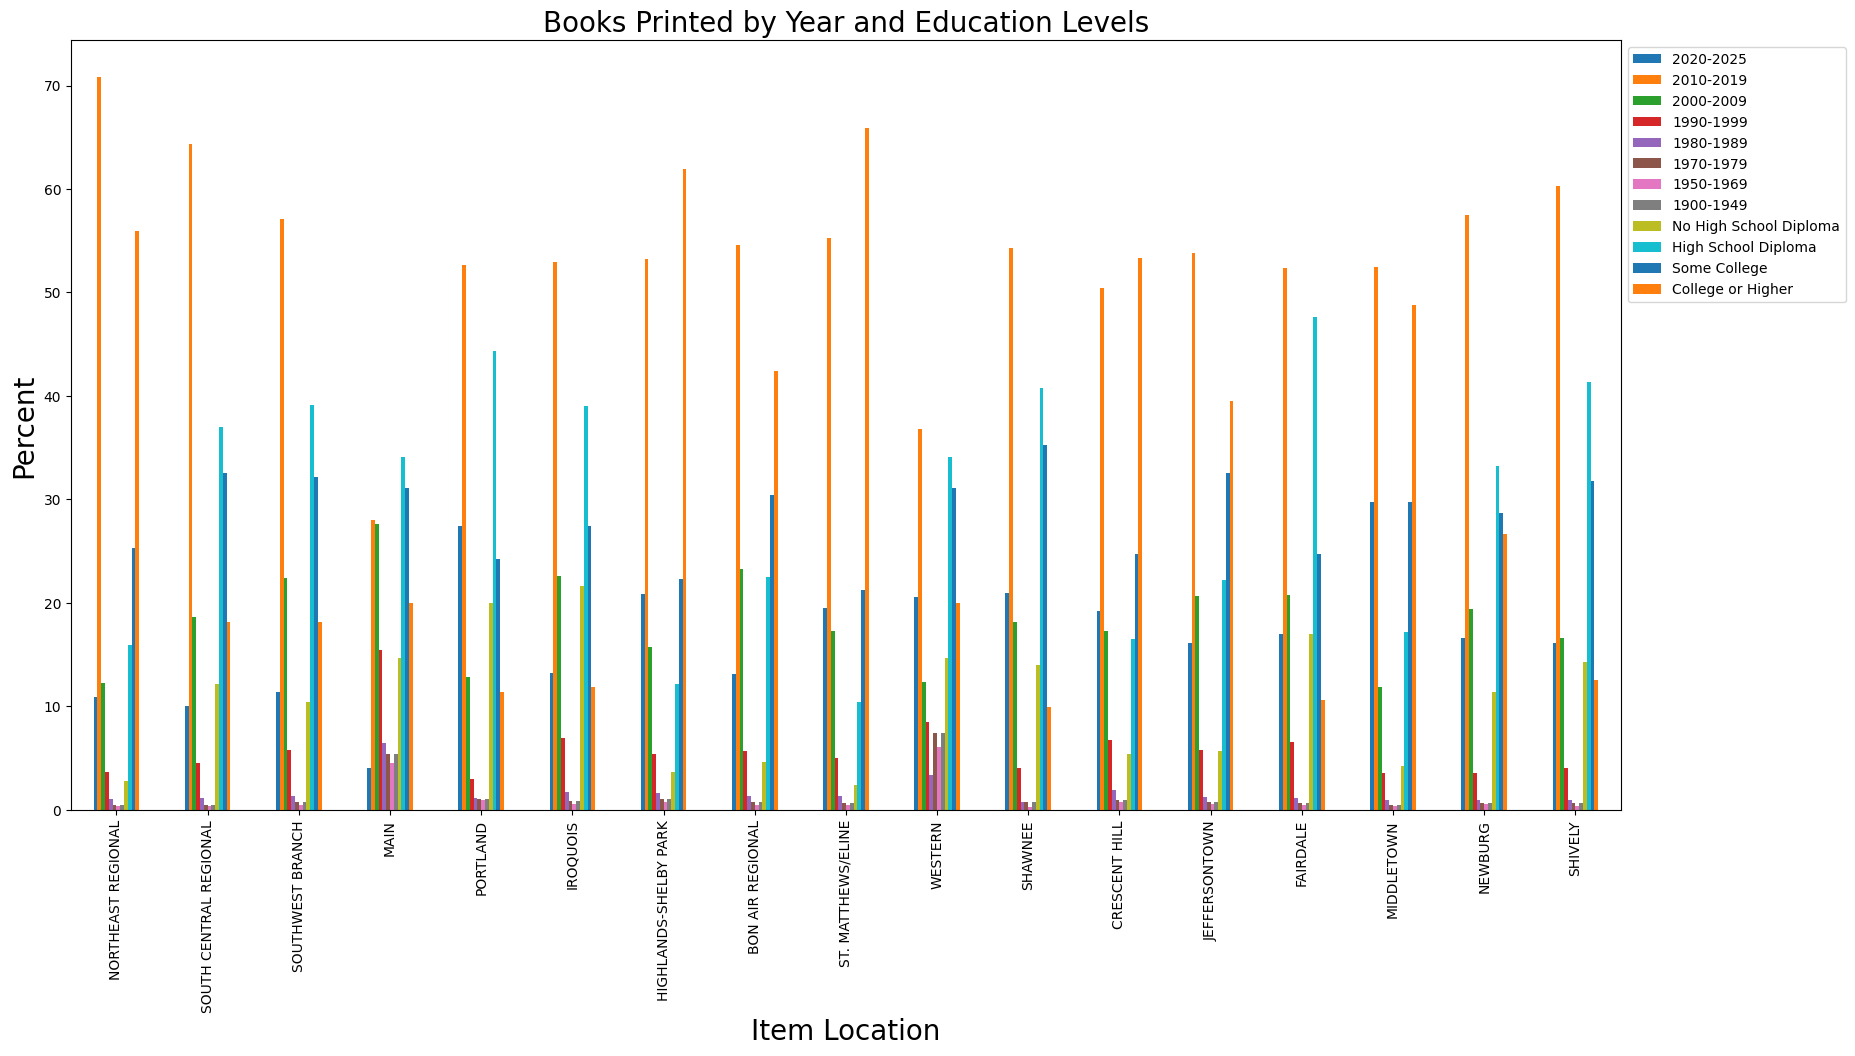

In [16]:
# basic visualization of the data from both datasets

ed_and_new.plot(x='ItemLocation', kind="bar", figsize=(20, 10))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Item Location', size = 20)
plt.ylabel('Percent', size = 20)
plt.title('Books Printed by Year and Education Levels', size = 20)
plt.show()

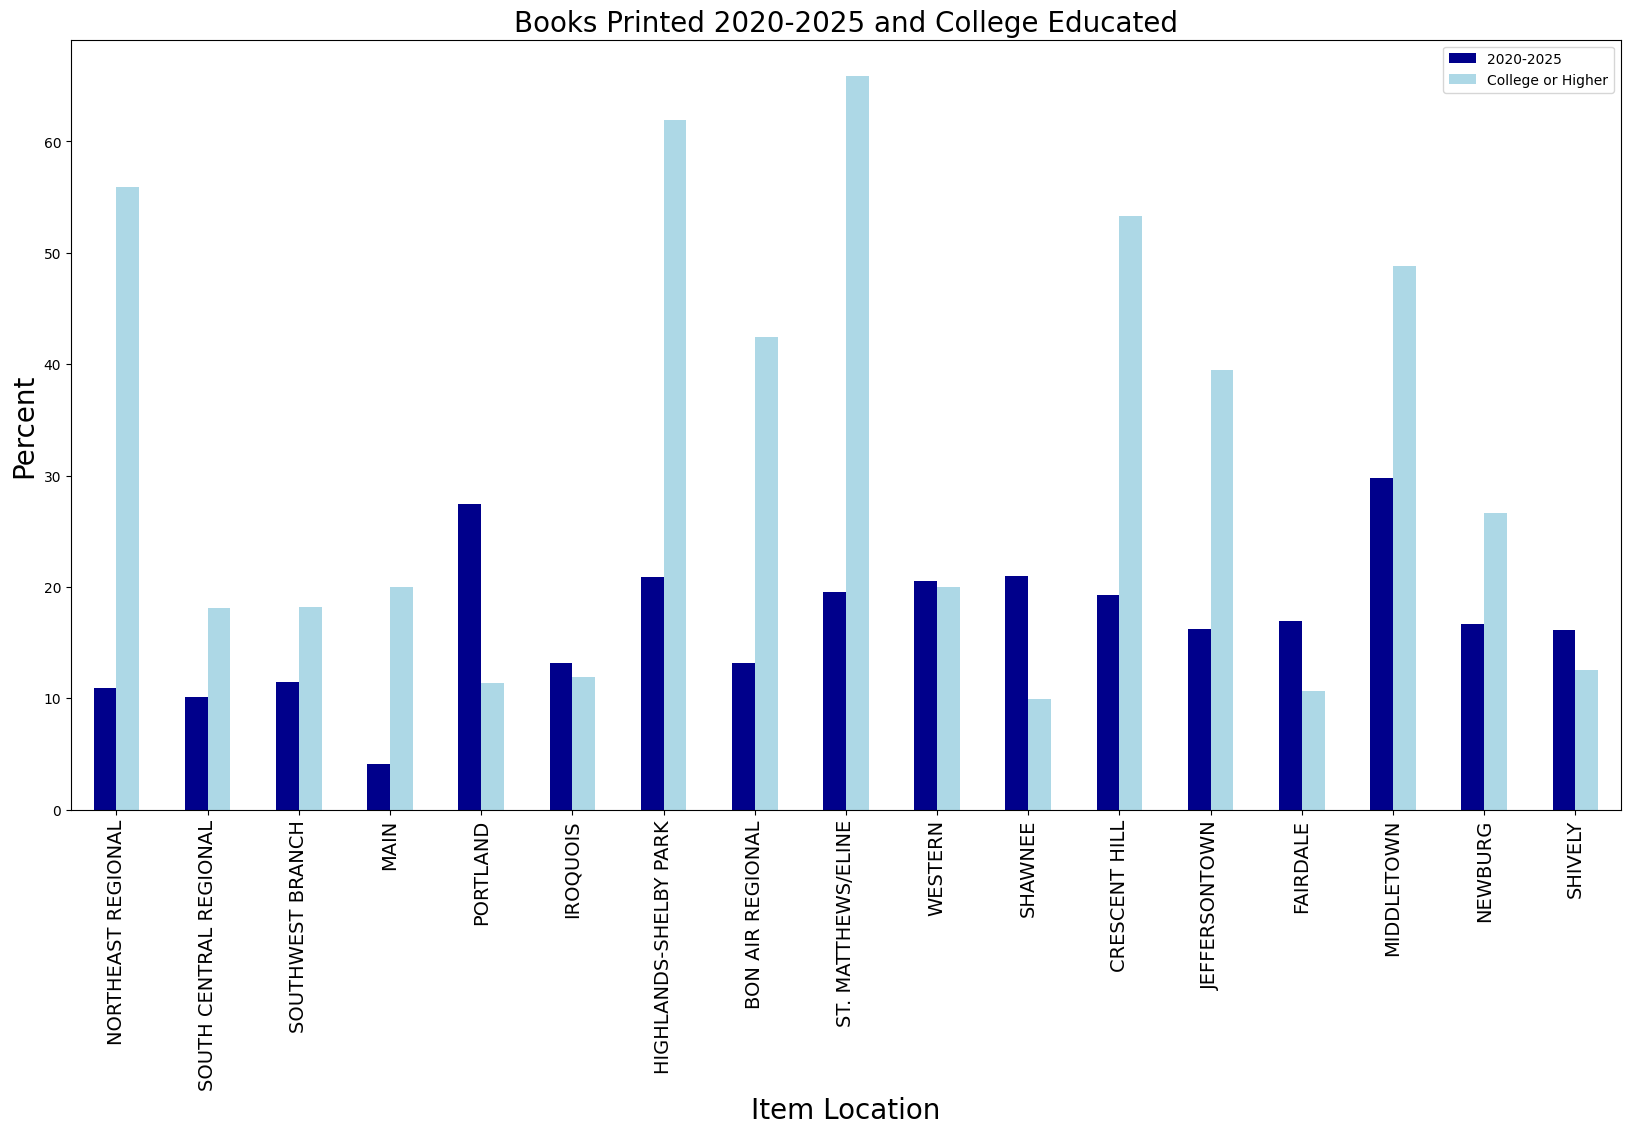

In [17]:
# More detailed bar chart showing specific features

colors = ['darkblue', 'lightblue']
ed_and_new[['2020-2025', 'College or Higher']].plot(kind="bar", color=colors, figsize=(20, 10))
plt.xticks(ticks=ed_and_new.index, labels=ed_and_new['ItemLocation'], size = 14)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Item Location', size = 20)
plt.ylabel('Percent', size = 20)
plt.title('Books Printed 2020-2025 and College Educated', size = 20)
plt.show()

Interpreting the data:

The Census data for education only surveys the adult population, so the library collections have been filtered to include only the adult books. Portland, Shawnee, and Fairdale have some of the lowest percentages of college graduates (and education levels in general) but fairly high percentages of books published in the past 5 years (same for books published between 2010-2019). So, the neighborhoods with higher education levels do not necessarily receive all the newest books (cf. Portland and St. Matthews/Eline or Northeast).

The higher recency rates for the lower education neighborhoods is a good sign for the adult collections of the libraries. However, the range is still significant. Not including the Main branch (which is going to be an outlier by the nature of being the central hub of the system), the range for 2020-2025 is 19.69% (max 29.78%, min 10.09%) and for 2010-2019 it is 34% (max 70.86%, min 36381%). This is a significant difference in which libraries are getting the latest books.

However, the size of the collections has not been considered in this study. So, a significantly smaller library collection with a higher percentage of new books could, in theory, have less new books than the larger library collection (e.g., the Main branch) with a much smaller new book collection. Further study on the sizes of these collections is needed to address how significant these differences in percentages are for the total number of new books available to each community. A brief examination of the sizes (see bar chart below) indicates that the size of the Portland library is significantly smaller than St. Matthews and the Northeast Regional branch is much larger than both. This difference could account for the differing percentages as the large percentage of new books at Portland is, likely, still less than the number of new books at the Northeast library. Further studies should be performed to verify (and quantify) this insight though.


In [100]:
data = {'NORTHEAST REGIONAL': [(librarysortedadult['ItemLocation'] == 'NORTHEAST REGIONAL').sum()],
        'SOUTH CENTRAL REGIONAL': [(librarysortedadult['ItemLocation'] == 'SOUTH CENTRAL REGIONAL').sum()], 
        'SOUTHWEST BRANCH': [(librarysortedadult['ItemLocation'] == 'SOUTHWEST BRANCH').sum()],
        'MAIN': [(librarysortedadult['ItemLocation'] == 'MAIN').sum()],
        'PORTLAND': [(librarysortedadult['ItemLocation'] == 'PORTLAND').sum()],
        'IROQUOIS': [(librarysortedadult['ItemLocation'] == 'IROQUOIS').sum()],
        'HIGHLANDS-SHELBY PARK': [(librarysortedadult['ItemLocation'] == 'HIGHLANDS-SHELBY PARK').sum()],
        'BON AIR REGIONAL': [(librarysortedadult['ItemLocation'] == 'BON AIR REGIONAL').sum()],
        'ST. MATTHEWS/ELINE': [(librarysortedadult['ItemLocation'] == 'ST. MATTHEWS/ELINE').sum()],
        'WESTERN': [(librarysortedadult['ItemLocation'] == 'WESTERN').sum()],
        'SHAWNEE': [(librarysortedadult['ItemLocation'] == 'SHAWNEE').sum()],
        'CRESCENT HILL': [(librarysortedadult['ItemLocation'] == 'CRESCENT HILL').sum()],
        'JEFFERSONTOWN': [(librarysortedadult['ItemLocation'] == 'JEFFERSONTOWN').sum()],
        'FAIRDALE': [(librarysortedadult['ItemLocation'] == 'FAIRDALE').sum()],
        'MIDDLETOWN': [(librarysortedadult['ItemLocation'] == 'MIDDLETOWN').sum()],
        'NEWBURG': [(librarysortedadult['ItemLocation'] == 'NEWBURG').sum()],
        'SHIVELY': [(librarysortedadult['ItemLocation'] == 'SHIVELY').sum()]}
collectiontotal = pd.DataFrame(data)
collection2 = collectiontotal.unstack()
collection2 = collection2.droplevel(level=1)
coll3 = collection2.to_frame()
coll3.columns = ['Collection Size']
coll4 = coll3.sort_values('Collection Size', ascending=False)

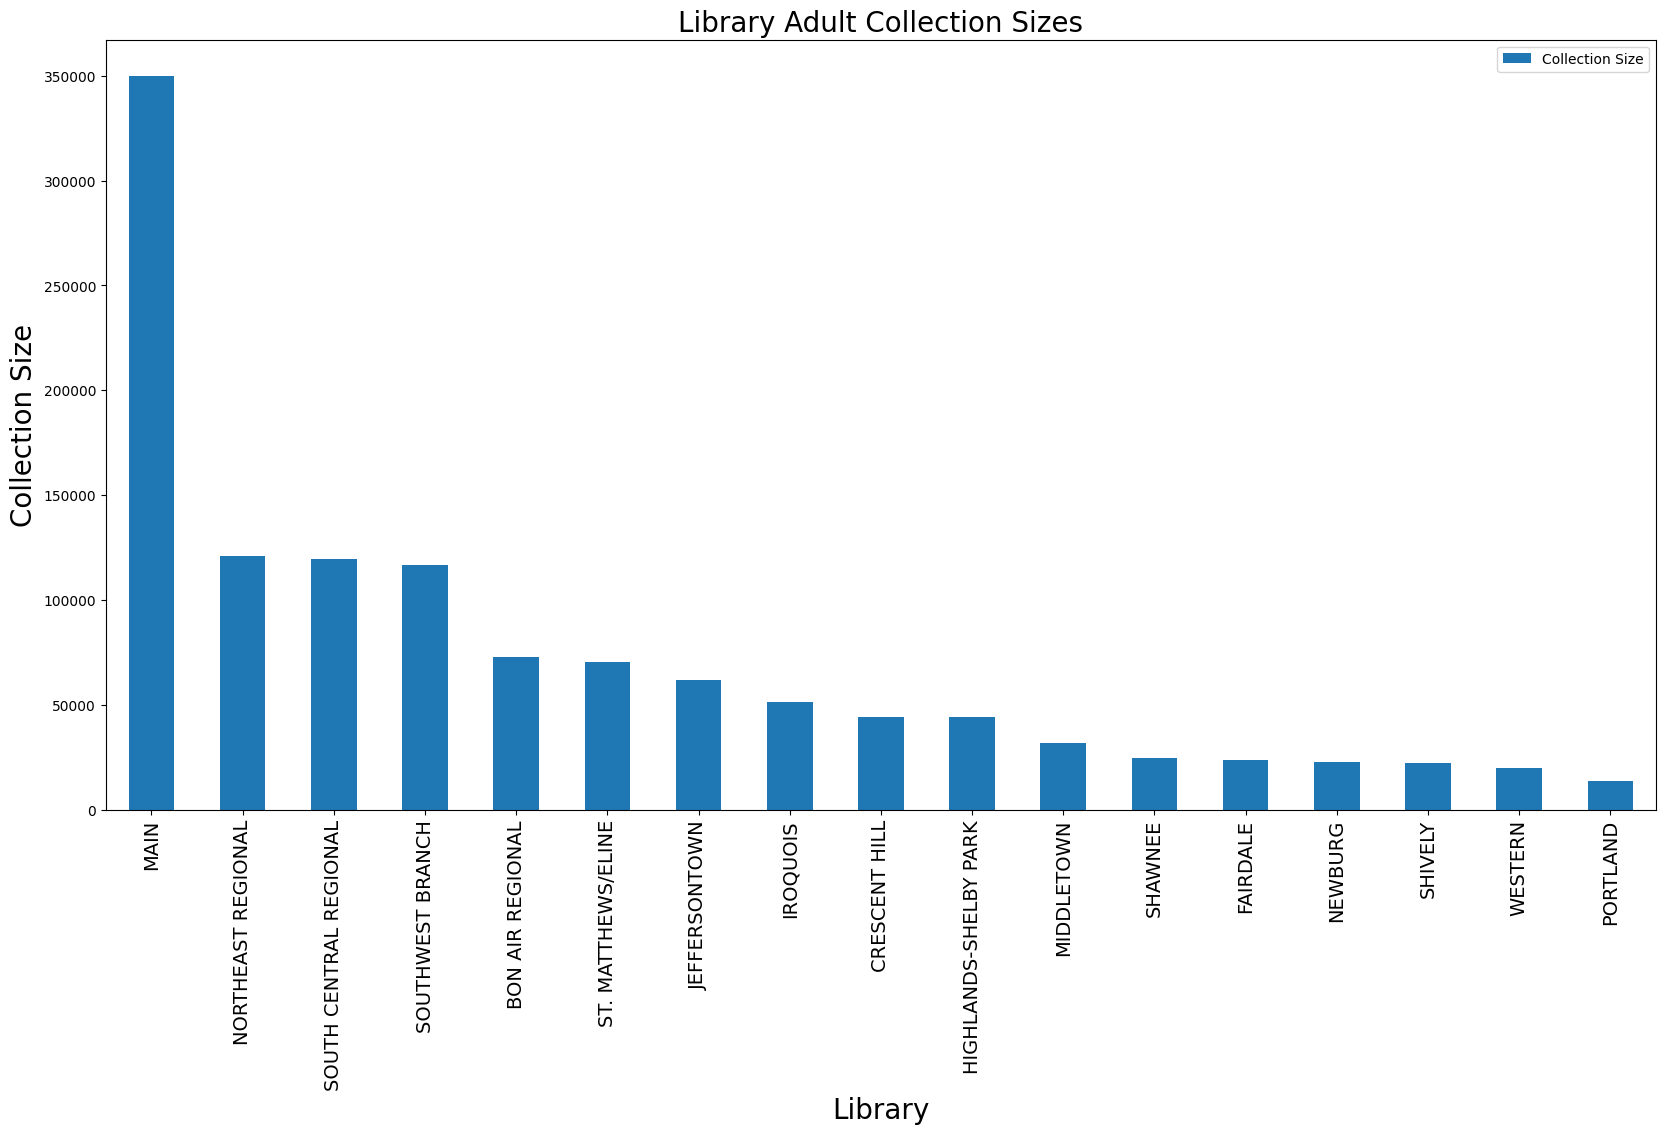

In [101]:

coll4.plot(kind="bar", figsize=(20, 10))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Library', size = 20)
plt.ylabel('Collection Size', size = 20)
plt.xticks(size = 14)
plt.title('Library Adult Collection Sizes', size = 20)
plt.show()